# CNN Model with VGG-16 QUANTIZATION Post Training


In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


## Pre-processing the Images

In [2]:
import os
import glob
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import plotly.express as px
from torchvision.models import VGG16_Weights

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CNN-CNR/Datasets/final-200-train-test/test', transform=transform)
calibration_datasets = datasets.ImageFolder(root='/content/drive/MyDrive/CNN-CNR/Datasets/calibration', transform=transform)


test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
calibration_loader = DataLoader(calibration_datasets, batch_size=32, shuffle=False, num_workers=2)



## Load and Modifyng VGG-16 Model

In [5]:
class QuantizedVGG16(nn.Module):
    def __init__(self, model):
        super(QuantizedVGG16, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
        self.features = model.features
        self.avgpool = model.avgpool
        self.classifier = model.classifier

    def forward(self, x):
        x = self.quant(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        x = self.dequant(x)
        return x

## Testing

In [6]:
def plot_per_class_accuracy_continuous(per_class_accuracy, class_names, color_scale='RdYlBu'):
    """
    Creates an interactive bar chart for per-class accuracy with a continuous color scale.

    Args:
        per_class_accuracy (list or array): Accuracy for each class.
        class_names (list): Names of the classes.
        color_scale (str or list, optional): Plotly color scale to use. Default is 'RdYlBu'.
    """
    # Create a DataFrame
    df = pd.DataFrame({
        'Class': class_names,
        'Accuracy': per_class_accuracy
    })

    fig = px.bar(
        df,
        x='Class',
        y='Accuracy',
        color='Accuracy',
        color_continuous_scale=color_scale,
        hover_data={'Class': True, 'Accuracy': ':.2f'},
        labels={'Accuracy': 'Accuracy'},
        title='Per-Class Accuracy',
        range_y=[0, 1]
    )

    fig.update_layout(
        xaxis_title='Classes',
        yaxis_title='Accuracy',
        coloraxis_colorbar=dict(
            title="Accuracy",
            tickvals=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
            ticktext=["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"]
        )
    )

    fig.update_traces(
        hovertemplate='<b>%{x}</b><br>Accuracy: %{y:.2f}<extra></extra>'
    )

    fig.show()


def group_classes_by_recall(per_class_recall, class_names, bins=None, plot=True):
    """
    Groups the number of classes based on their recall into specified ranges.

    Args:
        per_class_recall (list or array): Recall values for each class.
        class_names (list): List of class names corresponding to the recall values.
        bins (list of tuples, optional): List of (min, max) tuples defining recall ranges.
                                         Defaults to predefined ranges:
                                         [(0.9, 1.0), (0.8, 0.89), (0.7, 0.79), (0.6, 0.69), (0.0, 0.59)]
        plot (bool, optional): Whether to plot the group counts. Defaults to True.

    Returns:
        dict: A dictionary with bin labels as keys and counts as values.
    """
    if bins is None:
        bins = [
            (0.9, 1.0),
            (0.8, 0.899),
            (0.7, 0.799),
            (0.6, 0.699),
            (0.5, 0.599),
            (0.4, 0.499),
            (0.3, 0.399),
            (0.2, 0.299),
            (0.1, 0.199),
            (0.0, 0.1)
        ]

    # Define bin labels
    bin_labels = [
        '0.9 - 1.0',
        '0.8 - 0.899',
        '0.7 - 0.799',
        '0.6 - 0.699',
        '0.5 - 0.599',
        '0.4 - 0.499',
        '0.3 - 0.399',
        '0.2 - 0.299',
        '0.1 - 0.199',
        '< 0.1'
    ]

    # Initialize counts
    bin_counts = {label: 0 for label in bin_labels}
    bin_class_names = {label: [] for label in bin_labels}

    # Assign each class to a bin
    for recall, class_name in zip(per_class_recall, class_names):
        placed = False
        for (min_val, max_val), label in zip(bins, bin_labels):
            if min_val <= recall <= max_val:
                bin_counts[label] += 1
                bin_class_names[label].append(class_name)
                placed = True
                break
        if not placed:
            print(f"Recall value {recall} for class '{class_name}' does not fit into any bin.")

    # Print the counts
    print("\nNumber of classes in each recall range:")
    for label in bin_labels:
        print(f"{label}: {bin_counts[label]}")

    return bin_counts, bin_class_names

Plots Functions

In [7]:
import matplotlib.pyplot as plt


def plot_confusion_matrix(conf_matrix, class_names, save_path=None):

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d',
                xticklabels=class_names, yticklabels=class_names,
                cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved at: {save_path}")

    plt.show()

    plt.close()


def plot_true_false_positive(conf_matrix, class_names, save_path=None):

    total_set = conf_matrix.sum(axis=1)  # Total images per class
    true_positive = conf_matrix.diagonal()  # True positives
    false_positive = conf_matrix.sum(axis=0) - conf_matrix.diagonal()  # False positives

    plt.figure(figsize=(16, 8))
    x = np.arange(len(class_names))  # Indices for classes
    width = 0.3  # Width of each bar

    plt.bar(x - width, total_set, width=width, label='Total Set', color='blue')
    plt.bar(x, true_positive, width=width, label='True Positives (TP)', color='green')
    plt.bar(x + width, false_positive, width=width, label='False Positives (FP)', color='red')

    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.ylabel('Count')
    plt.xlabel('Classes')
    plt.title('True Positives and False Positives per Class')
    plt.legend(loc='upper right')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"True/False Positives chart saved at: {save_path}")

    plt.show()

    plt.close()


def plot_per_class_recall(per_class_recall, class_names, accuracy_threshold=0.8, save_path=None):

    plt.figure(figsize=(12, 6))
    plt.bar(class_names, per_class_recall, color='c')
    plt.axhline(y=accuracy_threshold, color='r', linestyle='--', label='Threshold')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Classes')
    plt.ylabel('Recall')
    plt.title('Recall per Class')
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Per-class recall chart saved at: {save_path}")


    plt.show()

    plt.close()



def write_results_to_txt(save_path: str,model_name: str, model_path: str, device: torch.device, overall_accuracy: float, precision: float, recall: float, f1: float, class_report: str,
    per_class_accuracy: list, class_names: list, zero_pred_classes: list, memory_used: float, execution_time: float, resources):

    txt_path = os.path.join(save_path, f"{model_name}.txt")
    with open(txt_path, 'w') as f:
        f.write(f"Model Evaluation Results\n")
        f.write(f"Model Path: {model_path}\n")
        f.write(f"Device: {device}\n\n")

        f.write(f"Overall Accuracy: {overall_accuracy:.4f}\n")
        f.write(f"Weighted Precision: {precision:.4f}\n")
        f.write(f"Weighted Recall: {recall:.4f}\n")
        f.write(f"Weighted F1-Score: {f1:.4f}\n\n")

        f.write("Classification Report:\n")
        f.write(class_report + "\n")

        f.write("Per-Class Accuracy:\n")
        for idx, class_name in enumerate(class_names):
            f.write(f" - {class_name}: {per_class_accuracy[idx]:.4f}\n")

        if zero_pred_classes:
            f.write("\nClasses with no predictions:\n")
            for class_name in zero_pred_classes:
                f.write(f" - {class_name}\n")
        else:
            f.write("\nAll classes have at least one prediction.\n")

        f.write(f"\nGPU memory used during the test: {memory_used:.2f} MB\n")
        f.write(f"Execution time: {execution_time:.2f} seconds\n")
        f.write(f"Resource used(execution_time / memory_used): {resources:.2f}\n")

    print(f"\nResults saved in: {txt_path}")

Testing Function

In [8]:
import numpy as np
import psutil
import time

def test_model(
    model_path: str,
    model_architecture: torch.nn.Module = None,
    test_loader: torch.utils.data.DataLoader = None,
    device: torch.device = None,
    class_names: list = None,
    accuracy_threshold: float = 0.8,
    save_path: str = None
) -> dict:

    if model_architecture is None:
        raise ValueError("model_architecture must be provided.")

    if test_loader is None:
        raise ValueError("test_loader must be provided.")

    if class_names is None:
        raise ValueError("class_names must be provided.")

    if not os.path.isfile(model_path):
        raise FileNotFoundError(f"The specified model_path does not exist or is not a file: {model_path}")

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if device.type == "cuda":
        before_memory = torch.cuda.memory_allocated(device)
    else:
        process = psutil.Process(os.getpid())
        before_memory = process.memory_info().rss

    # Misurazione tempo di inizio
    start_time = time.time()

    '''
    print(f'Loading model from: {model_path}')

    try:
        model_architecture.load_state_dict(torch.load(model_path, map_location=device))
    except RuntimeError as e:
        print(f"RuntimeError while loading model weights: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error while loading model: {e}")
        return None
    '''
    model_architecture.to(device)
    model_architecture.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_architecture(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Misurazione tempo di fine
    end_time = time.time()

    # Misurazione memoria dopo il test
    if device.type == "cuda":
        after_memory = torch.cuda.memory_allocated(device)
        peak_memory = torch.cuda.max_memory_allocated(device)
        memory_used = (peak_memory - before_memory) / (1024 ** 2)  # In MB
    else:
        process = psutil.Process(os.getpid())
        after_memory = process.memory_info().rss
        memory_used = (after_memory - before_memory) / (1024 ** 2)  # In MB

    overall_accuracy = accuracy_score(all_labels, all_preds)
    print(f'\nOverall Accuracy: {overall_accuracy:.4f}')

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    print(f'Weighted Precision: {precision:.4f}')
    print(f'Weighted Recall: {recall:.4f}')
    print(f'Weighted F1-Score: {f1:.4f}')

    conf_matrix = confusion_matrix(all_labels, all_preds)

    class_report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
    print('\nClassification Report:')
    print(class_report)

    report_dict = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
    per_class_recall = [report_dict[class_name]['recall'] for class_name in class_names]

    with np.errstate(divide='ignore', invalid='ignore'):
        per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
        per_class_accuracy = np.nan_to_num(per_class_accuracy)

    print('Per-Class Accuracy:')
    for idx, class_name in enumerate(class_names):
        print(f' - {class_name}: {per_class_accuracy[idx]:.4f}')

    predictions_per_class = conf_matrix.sum(axis=0)
    zero_pred_classes = [class_names[i] for i, count in enumerate(predictions_per_class) if count == 0]

    if zero_pred_classes:
        print(f"\nClasses with no predictions: {zero_pred_classes}")
    else:
        print("\nAll classes have at least one prediction.")

    execution_time = end_time - start_time
    resources = execution_time * memory_used if memory_used > 0 else float('inf')  # Opzionale

    if save_path is not None:
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        model_name = os.path.splitext(os.path.basename(model_path))[0]
        conf_matrix_path = os.path.join(save_path, f"{model_name}_conf_matrix.png")
        bar_plot_path = os.path.join(save_path, f"{model_name}_true_false_positive.png")
        recall_plot_path = os.path.join(save_path, f"{model_name}_recall_plot.png")


        write_results_to_txt(save_path=save_path, model_name=model_name, model_path=model_path, device=device, overall_accuracy=overall_accuracy,
            precision=precision, recall=recall, f1=f1, class_report=class_report, per_class_accuracy=per_class_accuracy, class_names=class_names,
            zero_pred_classes=zero_pred_classes, memory_used=memory_used, execution_time=execution_time, resources=resources )


        plot_confusion_matrix(conf_matrix, class_names, save_path=conf_matrix_path)
        plot_true_false_positive(conf_matrix, class_names, save_path=bar_plot_path)
        plot_per_class_recall(per_class_recall, class_names, accuracy_threshold=accuracy_threshold, save_path=recall_plot_path)

    results = {
        'overall_accuracy': overall_accuracy,
        'weighted_precision': precision,
        'weighted_recall': recall,
        'weighted_f1': f1,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'per_class_recall': per_class_recall,
        'per_class_accuracy': per_class_accuracy,
        'zero_pred_classes': zero_pred_classes
    }

    print(f"\nCPU memory used during the test: {memory_used:.2f} MB")  # CPU memory used during the test in MB
    print(f"Execution time: {execution_time:.2f} seconds")  # Total execution time in seconds
    print(f"Resource used(execution_time / memory_used): {resources:.2f}")  # Opzionale

    return results


## Quantization

In [9]:
def fuse_vgg16_model(model):
    """
    Applica la fusione dei moduli Conv + ReLU e Linear + ReLU per il modello VGG16.

    Args:
        model (nn.Module): Il modello VGG16 da fondere.
    """
    # Fusione per la parte "features"
    for idx in range(len(model.features) - 1):
        if isinstance(model.features[idx], nn.Conv2d) and isinstance(model.features[idx + 1], nn.ReLU):
            torch.quantization.fuse_modules(model.features, [str(idx), str(idx + 1)], inplace=True)

    # Fusione per la parte "classifier"
    for idx in range(len(model.classifier) - 1):
        if isinstance(model.classifier[idx], nn.Linear) and isinstance(model.classifier[idx + 1], nn.ReLU):
            torch.quantization.fuse_modules(model.classifier, [str(idx), str(idx + 1)], inplace=True)


In [10]:
def quantize_vgg16_post_training(model, calibration_loader, save_path=None):
    """
    Applies post-training quantization to the VGG16 model and optionally saves the quantized model.

    Args:
        model (nn.Module): The VGG16 model to quantize.
        calibration_loader (DataLoader): DataLoader for calibration.
        save_path (str, optional): Base path to save the quantized model. If None, the model will not be saved.

    Returns:
        nn.Module: The quantized model.
    """
    import datetime
    # Set the quantization backend
    torch.backends.quantized.engine = 'fbgemm'

    # Move the model to CPU
    device = torch.device("cpu")
    model.to(device)
    model.eval()

    # Fuse modules
    fuse_vgg16_model(model)

    # Set quantization configuration
    model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
    model.qconfig.activation.quant_min = 0.0
    model.qconfig.activation.quant_max = 1.0
    model.qconfig.weight.quant_min = 0.0
    model.qconfig.weight.quant_max = 1.0

    # Prepare the model for quantization
    torch.quantization.prepare(model, inplace=True)

    # Calibrate the model using calibration data
    with torch.no_grad():
        for inputs, _ in tqdm(calibration_loader, desc="Calibrating", leave=True):
            inputs = inputs.to(device)
            model(inputs)

    # Convert the model to a quantized version
    torch.quantization.convert(model, inplace=True)

    if save_path:
        # Convert to TorchScript
        scripted_model = torch.jit.script(model)

        # Save the TorchScript model
        scripted_model.save(save_path)

    #print(f"Quantization completed and model saved in {save_path}")

    return model



In [12]:
def load_quantized_vgg16_model(model_path):
  quant_model = torch.jit.load(model_path)
  quant_model.eval()
  print("Model Loaded!")

  return quant_model

In [13]:
def load_architecture_vgg16(model_path,dataset):

  class_names = test_dataset.classes

  device = torch.device('cpu')
  model_architecture = models.vgg16(weights='VGG16_Weights.DEFAULT')
  num_classes = len(class_names)
  model_architecture.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

  if model_path:
    model_architecture.load_state_dict(torch.load(model_path, map_location=device))

  model_architecture.to(device)

  return model_architecture, class_names, device

## MAIN

In [17]:
model_path = '/content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16/vgg16_model_01_25_2025_15_44_0.95125.pth'
model_architecture, class_names, device = load_architecture_vgg16(model_path, test_dataset)

<ipython-input-13-6c633600f56f>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_architecture.load_state_dict(torch.load(model_path, map_location=device))


In [18]:
quant_model = QuantizedVGG16(model_architecture)

quantized_model_save_path = '/content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-quant-post-model/vgg16-post-quant-model-final'

quantized_model = quantize_vgg16_post_training(quant_model, calibration_loader, save_path=quantized_model_save_path)

/usr/local/lib/python3.11/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
Calibrating: 100%|██████████| 12/12 [05:59<00:00, 30.00s/it]


In [19]:
load_quant_path = '/content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-quant-post-model/vgg16-post-quant-model-final'

load_quantized_model = load_quantized_vgg16_model(load_quant_path)

Model Loaded!


Evaluating: 100%|██████████| 32/32 [06:04<00:00, 11.38s/it]



Overall Accuracy: 0.9170
Weighted Precision: 0.9191
Weighted Recall: 0.9170
Weighted F1-Score: 0.9155

Classification Report:
                                precision    recall  f1-score   support

    Asterionellopsis glacialis       0.95      0.97      0.96        40
        Bacteriastrum furcatum       0.95      0.88      0.91        40
        Bacteriastrum jadranum       0.91      1.00      0.95        40
          Cerataulina pelagica       0.82      1.00      0.90        40
           Chaetoceros diadema       0.85      0.85      0.85        40
          Chaetoceros diversus       0.91      0.97      0.94        40
          Chaetoceros socialis       0.86      0.93      0.89        40
              Chaetoceros spp.       0.78      0.62      0.69        40
      Chaetoceros tortissimius       0.93      0.93      0.93        40
      Cylindrotheca closterium       0.89      1.00      0.94        40
   Dactyliosolen fragilissimus       0.91      1.00      0.95        40
        

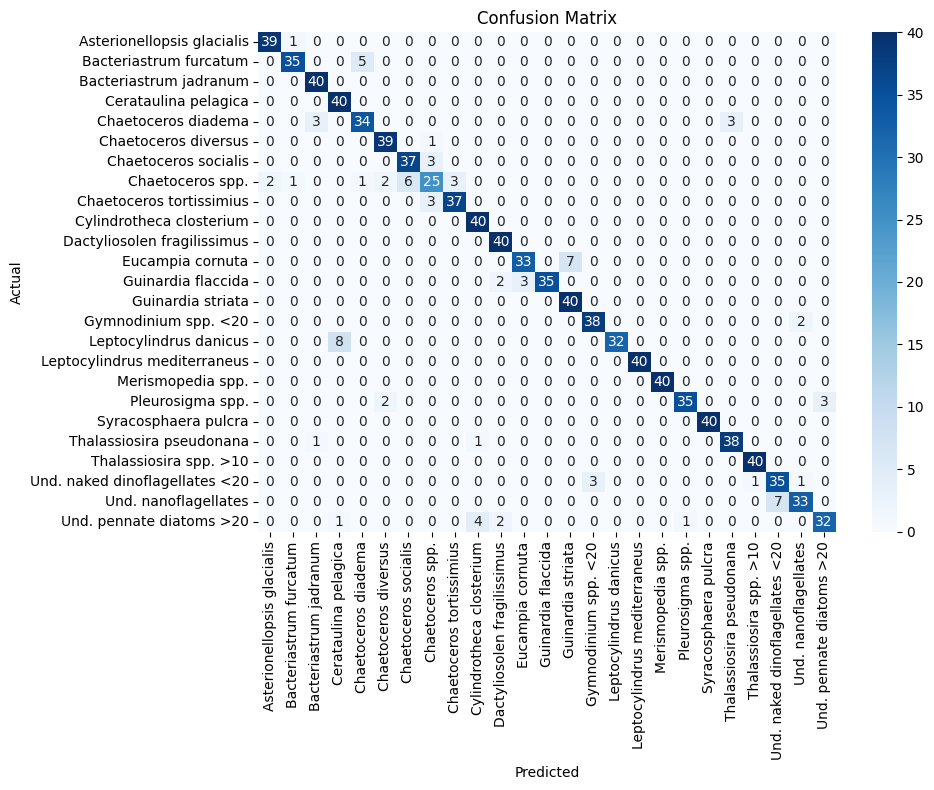

True/False Positives chart saved at: /content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-quant-post-model/vgg16_model_01_25_2025_15_44_0.95125_true_false_positive.png


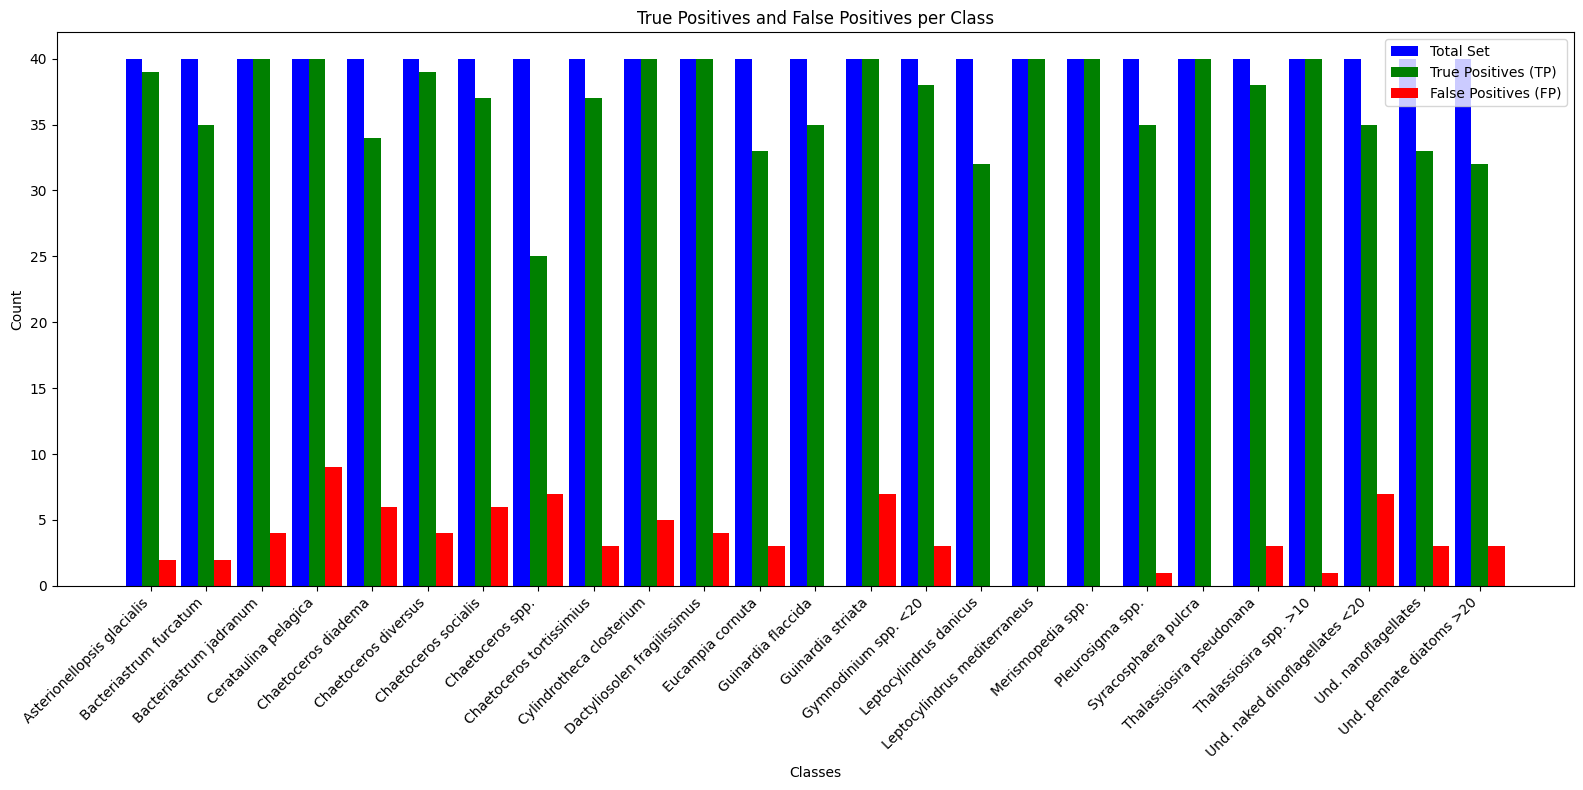

Per-class recall chart saved at: /content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-quant-post-model/vgg16_model_01_25_2025_15_44_0.95125_recall_plot.png


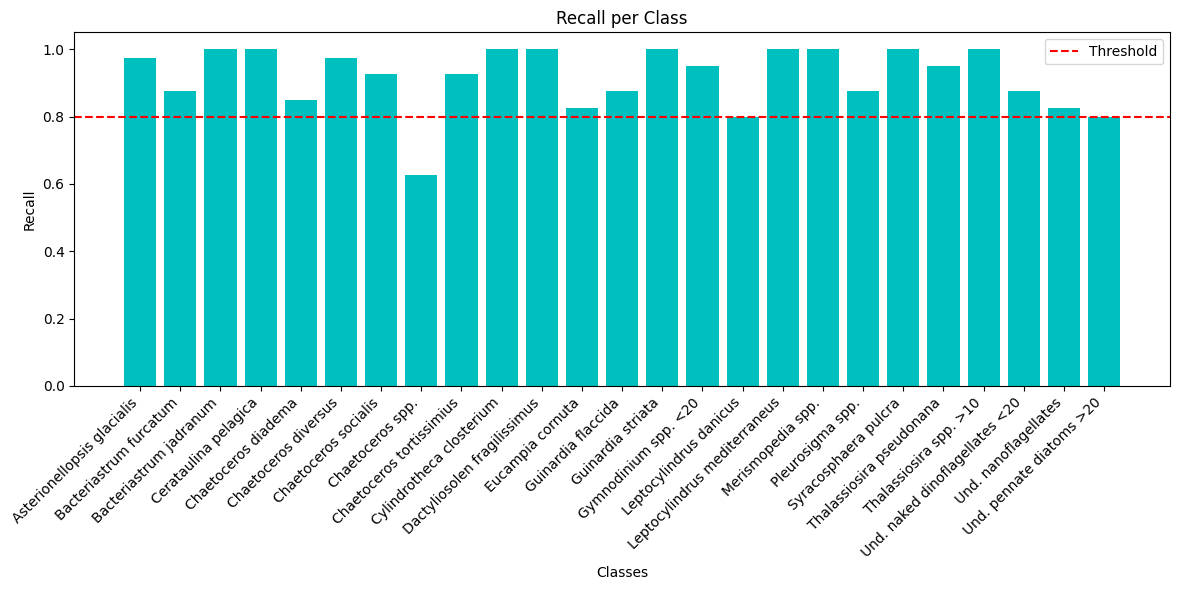


CPU memory used during the test: 217.71 MB
Execution time: 364.19 seconds
Resource used(execution_time / memory_used): 79287.15


In [20]:
save_path='/content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-quant-post-model'


results = test_model(
    model_path = model_path,
    model_architecture= load_quantized_model,
    test_loader= test_loader,
    class_names= class_names,
    accuracy_threshold=0.8,
    save_path= save_path)

